## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import albumentations as A # fast image agumentation library
from albumentations.pytorch.transforms import ToTensorV2 # 이미지 형 변환
#import torchvision.models as models

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

from transformers import BertTokenizerFast, BertModel, DistilBertModel

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)


c:\Users\mnh51\anaconda3\envs\tour2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# gpu 사용하기 위한 코드
# cuda가 설치되어 있으면 gpu

## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':8,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':1,
    'SEED':41
}
# 이미지 사이즈, 이폭, 학습률, 배치사이즈, 시드 고정

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [5]:
all_df = pd.read_csv('./train_bert.csv')

In [6]:
train_df, val_df, _, _ = train_test_split(all_df, all_df['cat3'], test_size=0.2, random_state=CFG['SEED'])
# train set, validation set 구별

## Label-Encoding

In [7]:
le = preprocessing.LabelEncoder()
le.fit(train_df['cat3'].values)
# 카테고리형 데이터를 수치형으로 변환하는 labelencoder

LabelEncoder()

In [8]:
train_df['cat3'] = le.transform(train_df['cat3'].values)
val_df['cat3'] = le.transform(val_df['cat3'].values)
# cat3에 labelencoder를 적용하기

## Vectorizer

In [9]:
import matplotlib.pyplot as plt


In [12]:
# vectorizer = CountVectorizer(max_features=4096)
# # overview를 vectorize하는 vectorizer 선언, 최대 특성 수는 4096

# train_vectors = vectorizer.fit_transform(train_df['overview'])
# train_vectors = train_vectors.todense()

# val_vectors = vectorizer.transform(val_df['overview'])
# val_vectors = val_vectors.todense()

# train_vectors = vectorizer.fit_transform(train_df['overview'])
# train_vectors = train_vectors.todense()

# val_vectors = vectorizer.transform(val_df['overview'])
# val_vectors = val_vectors.todense()
MAX_LEN = 512
train_vectors = []
len_list = []

character_remove = ["<br>", "<br />", "*", "※", "<strong>", "<strong/>", "-",]

for i, ov in enumerate(train_df['overview']):
    for char_remove in character_remove:
        ov = ov.replace(char_remove, "")
    
    ov = ov.split('.')
    ov = '. [SEP]'.join(ov)
    ov = ov.split('\n')
    ov = '. [SEP]'.join(ov)
    ov = "[CLS] " + ov

    tokenized_text = tokenizer.tokenize(ov)
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]
    len_list.append(len(input_ids))

    input_ids = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    attention_masks = []

    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    vec = np.array([
        input_ids,
        attention_masks,
    ])

    train_vectors.append(vec)

train_vectors = np.array(train_vectors)
print(train_vectors.shape)

val_vectors = []
for i, ov in enumerate(val_df['overview']):
    for char_remove in character_remove:
        ov = ov.replace(char_remove, "")
    
    ov = ov.split('.')
    ov = '. [SEP]'.join(ov)
    ov = ov.split('\n')
    ov = '. [SEP]'.join(ov)
    ov = "[CLS] " + ov

    tokenized_text = tokenizer.tokenize(ov)
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]
    input_ids = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    attention_masks = []

    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    vec = np.array([
        input_ids,
        attention_masks,
    ])

    val_vectors.append(vec)

val_vectors = np.array(val_vectors)
print(val_vectors.shape)

(13588, 2, 1, 512)
(3398, 2, 1, 512)


(array([3.456e+03, 5.036e+03, 2.819e+03, 1.166e+03, 4.830e+02, 2.240e+02,
        1.480e+02, 8.700e+01, 5.600e+01, 3.900e+01, 2.200e+01, 1.900e+01,
        9.000e+00, 6.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([   6.        ,  112.43333333,  218.86666667,  325.3       ,
         431.73333333,  538.16666667,  644.6       ,  751.03333333,
         857.46666667,  963.9       , 1070.33333333, 1176.76666667,
        1283.2       , 1389.63333333, 1496.06666667, 1602.5       ,
        1708.93333333, 1815.36666667, 1921.8       , 2028.23333333,
        2134.66666667, 2241.1       , 2347.53333333, 2453.96666667,
        2560.4       , 2666.83333333, 2773.26666667, 2879.7       ,
        2986.13333333, 3092.56666667, 3199.        ]),
 <BarContainer object of 30 artists>)

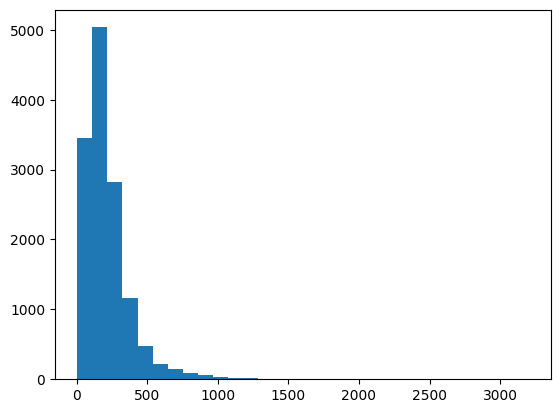

In [13]:
plt.hist(len_list, bins=30)

## CustomDataset

In [14]:
# Dataset 생성
class CustomDataset(Dataset):
    def __init__(self, img_path_list, text_vectors, label_list, transforms, infer=False):
        self.img_path_list = img_path_list
        self.text_vectors = text_vectors
        self.label_list = label_list
        self.transforms = transforms
        self.infer = infer
        
    def __getitem__(self, index):
        # NL
        token_vec = self.text_vectors[index]

        # Image 읽기
        img_path = self.img_path_list[index]
        #image = Image.open(img_path)
        #image = cv2.imread(img_path)
        
        # if self.transforms is not None:
        #     image = self.transforms(image=image)['image'] # transforms(=image augmentation) 적용

         # Label
        if self.infer: # infer == True, test_data로부터 label "결과 추출" 시 사용
            return torch.tensor(1), token_vec
        else: # infer == False
            label = self.label_list[index] # dataframe에서 label 가져와 "학습" 시 사용
            return torch.tensor(1), token_vec, label
        
    def __len__(self):
        return len(self.img_path_list)

In [15]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

- albumentations -> fast image augmentation library

- albumentations.Compose -> transform = A.Compose([])을 이용하여 이미지와 라벨 각각에 Augmentation을 적용하기 위한 객체를 생성

- albumentations.Resize(128, 128) -> 128*128 size로 resize
- albumentations.Normalize() -> 입력 받은 이미지 값의 범위를 (0, 255) → (-1, 1) 범위로 줄여주는 역할, 위에서는 평균값, 분산값, 최대 픽셀값으로 img = (img - mean * max_pixel_value) / (std * max_pixel_value)을 계산.
- ToTensorV2 -> tensor형 변환

In [16]:
# __init__(self, img_path_list, text_vectors, label_list, transforms, infer=False)
train_dataset = CustomDataset(train_df['img_path'].values, train_vectors, train_df['cat3'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) # 6

val_dataset = CustomDataset(val_df['img_path'].values, val_vectors, val_df['cat3'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0) # 6

- DataLoader: Dataset와 Sampler를 결합하고 지정된 데이터 세트에 대해 반복 가능한 기능을 제공.    
    - dataset (Dataset): 데이터를 로드할 데이터 집합.   
    - batch_size (int, optional): **how many samples** per batch to load (default: ``1``).   
    - num_workers (int, optional): **how many subprocesses** to use for data loading. ``0`` means that the data will be    loaded in the main process. (default: ``0``) -> 6으로 설정 시 안돌아감([Errno 32] Broken pipe). 0으로 변경해야 됨

## Model Define

In [17]:

class CustomModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(CustomModel, self).__init__()
        self.model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=128)
        self.model.cuda()

        # Classifier
        # self.classifier = nn.Sequential(
        #     nn.AdaptiveAvgPool1d(1),
        #     nn.Flatten(),
        #     nn.Linear(768, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, num_classes),
        # )

    def forward(self, img, text):
        # x = self.model(
        #     text[:,0,0,:512], 
        #     token_type_ids=None, 
        #     attention_mask=[:,1,0,:512], 
        # )

        
        # x = self.model_bert(
        #     input_ids=text[:,0,0,:512],
        #     attention_mask=text[:,1,0,:512],
        #     token_type_ids=text[:,2,0,:512],
        # ).last_hidden_state
        # x=x.transpose(1,2)
        # print(x.shape)

        # x = self.classifier(x)
        
        return text

결론:
- Image: conv -> ReLU -> MaxPooling -> conv -> relu -> maxpooling -> conv -> relu -> maxpooling -> conv -> relu -> maxpooling

- Text: linear -> relu -> linear

- classifier : linear

## Train

In [18]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device) # gpu(cpu)에 적용
    criterion = nn.CrossEntropyLoss().to(device) # CrossEntropyLoss: 다중분류를 위한 손실함수
    best_score = 0
    best_model = None # 최고의 모델을 추출하기 위한 파라미터
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train() # 학습시킴.
        train_loss = []
        correct = 0
        for img, text, label in tqdm(iter(train_loader)): # train_loader에서 img, text, label 가져옴
            img = img.float().to(device)
            text = text.to(device).type(torch.LongTensor).to(device)
            label = label.type(torch.LongTensor) # label type을 LongTensor로 형변환, 추가하여 에러 해결
            label = label.to(device)
            
            optimizer.zero_grad() # 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭하는 걸 방지, 0으로 초기화

            model_pred = model(
                text[:,0,0,:512], 
                token_type_ids=None, 
                attention_mask=text[:,1,0,:512], 
            ).logits # 예측
            
            loss = criterion(model_pred, label) # 예측값과 실제값과의 손실 계산

            loss.backward() # .backward() 를 호출하면 역전파가 시작
            optimizer.step() # optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정

            train_loss.append(loss.item())

            pred_label = torch.argmax(model_pred, dim=1)
            correct += (label == pred_label).float().sum()
        
        accuracy =  correct / float(len(train_loader.dataset))
        # trainset, not train_loader
        # probably x in your case

        print("Train Accuracy = {}".format(accuracy))
            
        # 모든 train_loss 가져옴
        tr_loss = np.mean(train_loss)
            
        val_loss, val_score = validation(model, criterion, val_loader, device) # 검증 시작, 여기서 validation 함수 사용
            
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step()
            # scheduler의 의미: Learning Rate Scheduler => learning rate를 조절한다. 
            # DACON에서는 CosineAnnealingLR 또는 CosineAnnealingWarmRestarts 를 주로 사용한다.
            
        if best_score < val_score: # 최고의 val_score을 가진 모델에 대해서만 최종적용을 시킴
            best_score = val_score
            best_model = model
    
    return best_model # val_score가 가장 높은 모델을 출력

In [19]:
def score_function(real, pred):
    return f1_score(real, pred, average="weighted")

def validation(model, criterion, val_loader, device):
    model.eval() # nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수
    
    model_preds = [] # 예측값
    true_labels = [] # 실제값
    
    val_loss = []
    
    with torch.no_grad():
        for img, text, label in tqdm(iter(val_loader)): # val_loader에서 img, text, label 가져옴
            img = img.float().to(device)
            text = text.to(device).type(torch.LongTensor).to(device)
            label = label.type(torch.LongTensor) # label type을 LongTensor로 형변환, 추가하여 에러 해결
            label = label.to(device)
            
            model_pred = model(
                text[:,0,0,:512], 
                token_type_ids=None, 
                attention_mask=text[:,1,0,:512], 
            ).logits # 예측
            #model_pred = model(img, text)
            
            loss = criterion(model_pred, label) # 예측값, 실제값으로 손실함수 적용 -> loss 추출
            
            val_loss.append(loss.item()) # loss 출력, val_loss에 저장
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
        
    test_weighted_f1 = score_function(true_labels, model_preds) # 실제 라벨값들과 예측한 라벨값들에 대해 f1 점수 계산
    return np.mean(val_loss), test_weighted_f1 # 각각 val_loss, val_score에 적용됨

## Run!!

In [20]:
#model = CustomModel()
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=128)

#optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

total_steps = len(train_loader.dataset) * CFG['EPOCHS']

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

KeyboardInterrupt: 

In [ ]:
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

def xgb_bo(gamma,max_depth, subsample):
    xgb_params = {
        'gamma' : int(round(gamma)),
        'max_depth' : int(round(max_depth)),
        'subsample' : int(round(subsample)),      
    }

    xgb_clf = XGBClassifier(**xgb_params)
    
    xgb_clf.fit(train_dataset.text_vectors,train_dataset.label_list)

    score = accuracy_score(val_dataset.label_list, xgb_clf.predict(val_dataset.text_vectors))

    return score

xgb_parameter_bounds = {
    'gamma' : (0,10),
    'max_depth' : (1,3), # 나무의 깊이
    'subsample' : (0.5,1)
}

BO_xgb = BayesianOptimization(f = xgb_bo, pbounds = xgb_parameter_bounds,random_state = 0)

# Bayesian Optimization을 실행해보세요

BO_xgb.maximize(init_points = 5, n_iter = 5)



# XGBoost Train

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

#BOW_XGB = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, objective="multi:softprob", random_state=1, tree_method='gpu_hist', predictor='gpu_predictor')
BOW_XGB = xgb.XGBClassifier(max_depth=3, n_estimators=100, objective="multi:softprob")
BOW_XGB.fit(train_dataset.text_vectors, train_dataset.label_list)


train_score = BOW_XGB.score(train_dataset.text_vectors, train_dataset.label_list)
val_score = BOW_XGB.score(val_dataset.text_vectors, val_dataset.label_list)
print("Averaged train CV Accuracy: %0.2f (+/- %0.2f)" % (train_score.mean(), train_score.std() * 2))
print("Averaged val CV Accuracy: %0.2f (+/- %0.2f)" % (val_score.mean(), val_score.std() * 2))


Averaged train CV Accuracy: 0.99 (+/- 0.00)
Averaged val CV Accuracy: 0.56 (+/- 0.00)


In [ ]:
def softmax(x):
    max = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

result = BOW_XGB.predict_proba(val_dataset.text_vectors)
result = softmax(result)
result[0], val_dataset.label_list[0]

(array([0.00776025, 0.00775048, 0.00774799, 0.0078957 , 0.00774468,
        0.00775019, 0.00774485, 0.00774694, 0.00774736, 0.00774509,
        0.00774565, 0.00790768, 0.00774506, 0.0077469 , 0.00774525,
        0.00774572, 0.00777256, 0.00775631, 0.00775758, 0.00775535,
        0.00776521, 0.00805745, 0.00774643, 0.00774767, 0.007745  ,
        0.0077451 , 0.0077516 , 0.00774597, 0.00774909, 0.00774504,
        0.00774586, 0.007753  , 0.00774495, 0.00774577, 0.00774477,
        0.00774454, 0.00774637, 0.00774577, 0.00774695, 0.00778864,
        0.00774546, 0.00787829, 0.0077458 , 0.00774451, 0.00775682,
        0.00774643, 0.00774597, 0.00774812, 0.00774426, 0.00774803,
        0.00774612, 0.00774564, 0.00779119, 0.00776246, 0.00775944,
        0.00775311, 0.00774866, 0.00774756, 0.00778362, 0.0077457 ,
        0.00774733, 0.0077507 , 0.00774624, 0.00774527, 0.00774849,
        0.00774641, 0.00774565, 0.00774784, 0.00774593, 0.00774507,
        0.00774595, 0.00774807, 0.00774763, 0.00

# NB Train

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(train_dataset.text_vectors, train_dataset.label_list)

train_score = nb_classifier.score(train_dataset.text_vectors, train_dataset.label_list)
val_score = nb_classifier.score(val_dataset.text_vectors, val_dataset.label_list)

print("Averaged train CV Accuracy: %0.2f (+/- %0.2f)" % (train_score.mean(), train_score.std() * 2))
print("Averaged val CV Accuracy: %0.2f (+/- %0.2f)" % (val_score.mean(), val_score.std() * 2))

MultinomialNB()

# RandomForest Train

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)
rf.fit(train_dataset.text_vectors, train_dataset.label_list)

train_score = rf.score(train_dataset.text_vectors, train_dataset.label_list)
val_score = rf.score(val_dataset.text_vectors, val_dataset.label_list)

print("Averaged train CV Accuracy: %0.2f (+/- %0.2f)" % (train_score.mean(), train_score.std() * 2))
print("Averaged val CV Accuracy: %0.2f (+/- %0.2f)" % (val_score.mean(), val_score.std() * 2))

KeyboardInterrupt: 

In [ ]:
train_score = rf.score(train_dataset.text_vectors, train_dataset.label_list)
val_score = rf.score(val_dataset.text_vectors, val_dataset.label_list)

print("Averaged train CV Accuracy: %0.2f (+/- %0.2f)" % (train_score.mean(), train_score.std() * 2))
print("Averaged val CV Accuracy: %0.2f (+/- %0.2f)" % (val_score.mean(), val_score.std() * 2))

Averaged train CV Accuracy: 0.36 (+/- 0.00)
Averaged val CV Accuracy: 0.35 (+/- 0.00)


# Load Test Dataset

In [ ]:
# load test dataset
test_df = pd.read_csv('./test.csv')
test_overview = []
for overview in test_df['overview']:
    arr = mecab.nouns(overview)
    noun_str = ' '.join(arr)
    test_overview.append(noun_str)

test_vectors = vectorizer.transform(test_overview)
test_vectors = test_vectors.todense()

test_dataset = CustomDataset(test_df['img_path'].values, test_vectors, None, test_transform, True)

# Predict

In [ ]:
# Make prediction 
result = BOW_XGB.predict(test_dataset.text_vectors)

submit = pd.read_csv('./sample_submission.csv')
submit['cat3'] = le.inverse_transform(result)
submit.to_csv('./submit_xgb.csv', index=False)

Averaged train CV Accuracy: 0.88 (+/- 0.00)
Averaged val CV Accuracy: 0.73 (+/- 0.00)
[118 121 118 ...  73 118  44]
(7280,)


## Inference

In [ ]:
test_df = pd.read_csv('./test.csv')
test_vectors = vectorizer.transform(test_df['overview'])
test_vectors = test_vectors.todense()

In [ ]:
test_dataset = CustomDataset(test_df['img_path'].values, test_vectors, None, test_transform, True)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, deivce):
    model.to(device)
    model.eval()
    
    model_preds = []
    
    with torch.no_grad():
        for img, text in tqdm(iter(test_loader)):
            img = img.float().to(device)
            text = text.to(device)
            
            model_pred = model(img, text)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
    # img, text에 따른 예측값들을 model_preds 배열에 넣어 리턴
    return model_preds

In [ ]:
preds = inference(infer_model, test_loader, device)

100%|██████████| 114/114 [01:45<00:00,  1.08it/s]


## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['cat3'] = le.inverse_transform(preds)

In [ ]:
submit.to_csv('./submit_jgw.csv', index=False)
# 제출 파일로 저장